# Climate event detection task
Sandbox for preprocessing and first learning test

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
import os
import shutil
import sys
sys.path.append('../..')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import cartopy.crs as ccrs

In [3]:
import h5py
import matplotlib.patches as patches

In [4]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

List of parameters:
* TMQ: Total (vertically integrated) precipitatable water
* U850: Zonal wind at 850 mbar pressure surface
* V850: Meridional wind at 850 mbar pressure surface
* UBOT: Lowest model level zonal wind
* VBOT: Lowest model level meridional wind
* QREFHT: Reference height humidity
* PS: Surface pressure
* PSL: sea level pressure
* T200: temp at 200 mbar pressure surface
* T500: temp at 500 mbar pressure surface
* PRECT: Total (convective and large-scale) precipitation rate (liq + ice)
* TS: Surface temperature (radiative)
* Z100: Geopotential Z at 100 mbar pressure surface
* Z200: Geopotential Z at 200 mbar pressure surface
* ZBOT: Lowest model level height

resolution of 768 x 1152 equirectangular grid (25-km at equator)

The labels are 0 for background class, 1 for tropical cyclone, and 2 for atmoshperic river

In [13]:
stats = h5py.File('../../data/Climate/stats.h5')
stats = stats['climate']["stats"] # (16 X 4) (mean, max, min, std)

In [84]:
year, month, day, hour, run = 2106, 1, 1, 0, 1
datapath = '../../data/Climate/data-{}-{:0>2d}-{:0>2d}-{:0>2d}-{}.h5'.format(year, month, day, hour, run)

In [85]:
h5f = h5py.File(datapath)
data = h5f['climate']["data"] # (16,768,1152) numpy array
labels = h5f['climate']["labels"] # (768,1152) numpy array

In [86]:
lon_ = np.arange(1152)/1152*360
lat_ = np.arange(768)/768*180-90
lon, lat = np.meshgrid(lon_, lat_)

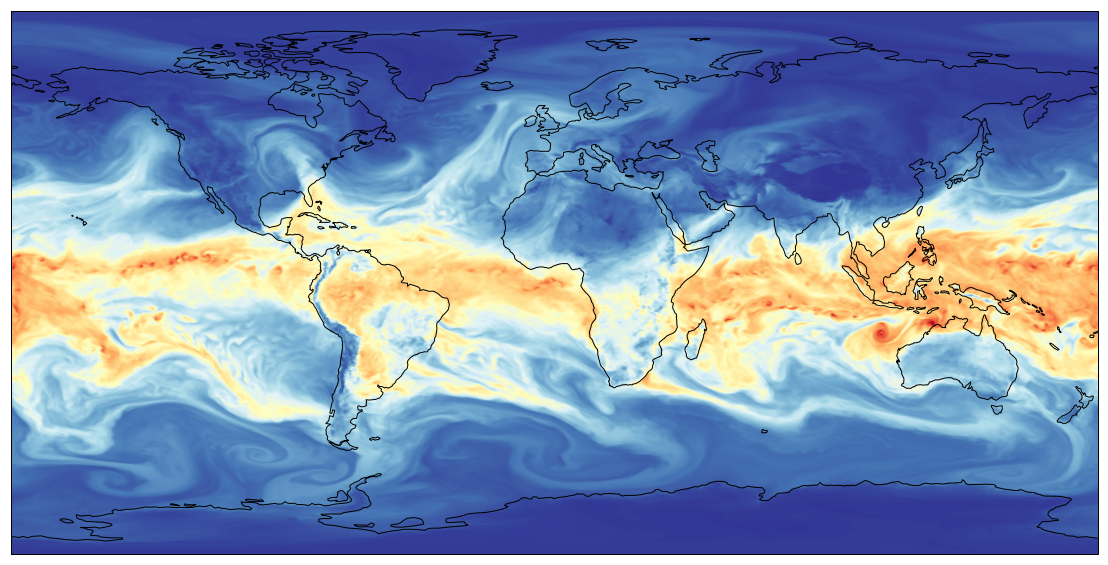

In [87]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(lon, lat, s=1,
            c=data[0,:,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

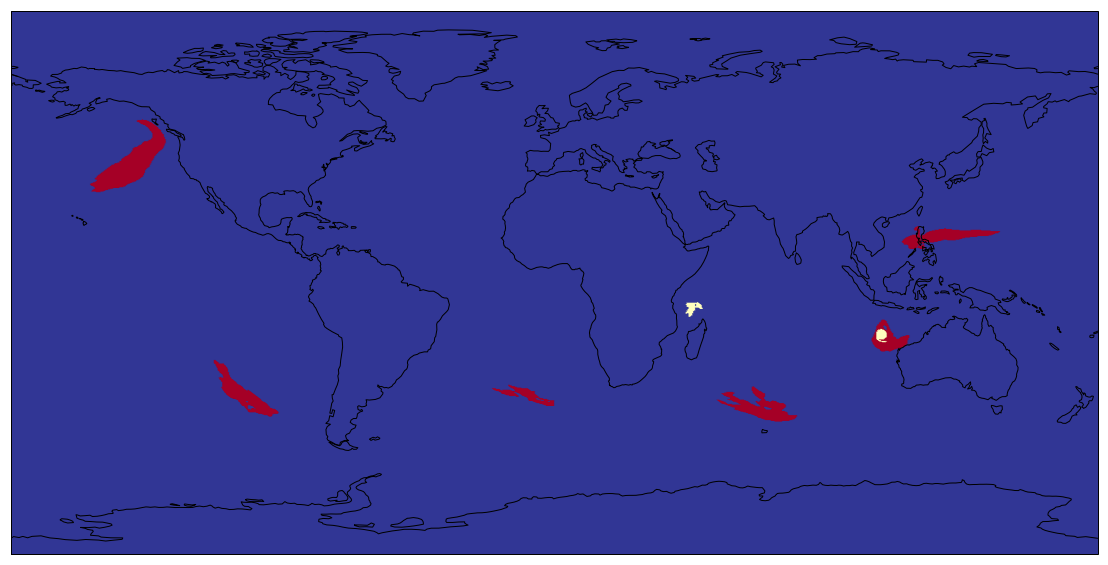

In [88]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(lon, lat, s=1,
            c=labels[:,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

In [83]:
from scipy.interpolate import griddata, RectBivariateSpline, RegularGridInterpolator, LinearNDInterpolator, interp2d, NearestNDInterpolator

In [134]:
from scipy.interpolate import griddata#, RectBivariateSpline, RegularGridInterpolator
Nside = 32
pix = np.arange(12*Nside**2)
coords_hp = hp.pix2ang(Nside, pix, nest=True, lonlat=True)
coords_hp = np.asarray(coords_hp).T
# lon_rad, lat_rad = np.deg2rad(lon), np.deg2rad(lat)
coords_map = hp.ang2vec(lon, lat, lonlat=True).reshape((-1, 3))
coords_map = np.stack([lon, lat], axis=-1).reshape((-1, 2))
# map_hp = griddata(coords_map, images[0,0].flatten(), coords_hp, 'linear')

In [22]:
t = time.time()
map_hp1 = griddata(coords_map, data[0].flatten(), coords_hp, 'linear')
print("time taken:", time.time()-t)

t = time.time()
f = RegularGridInterpolator((lon_, lat_), data[0].T)
map_hp3 = f(coords_hp)
print("time taken:", time.time()-t)

time taken: 22.371877908706665
time taken: 0.011130094528198242


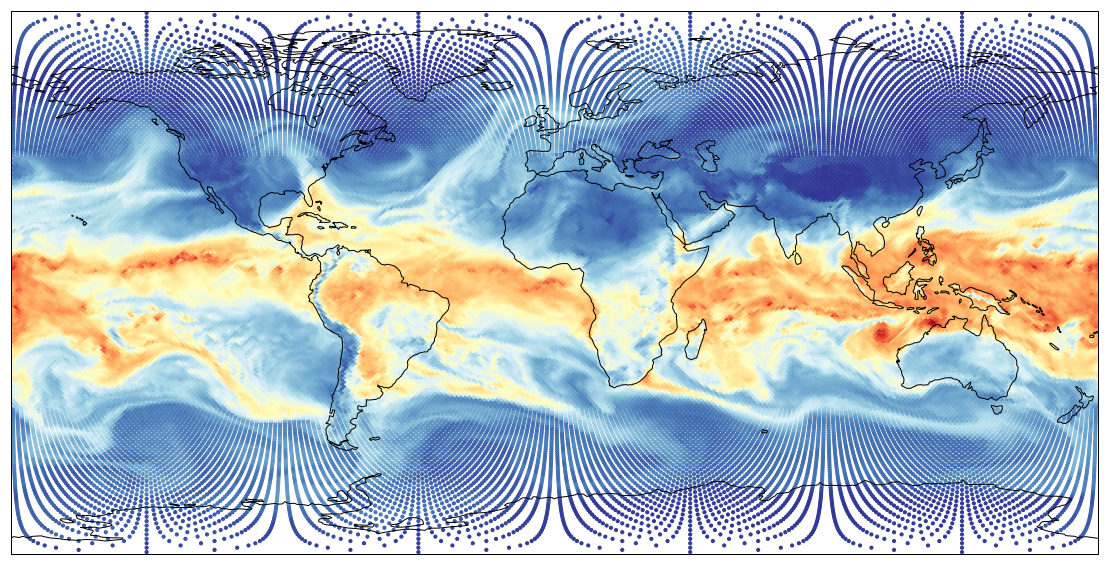

In [23]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
            c=map_hp3, cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

In [93]:
coords_map.shape

(884736, 2)

In [94]:
f = NearestNDInterpolator(coords_map, labels[:].flatten(), rescale=False)
new_labels = f(coords_hp)

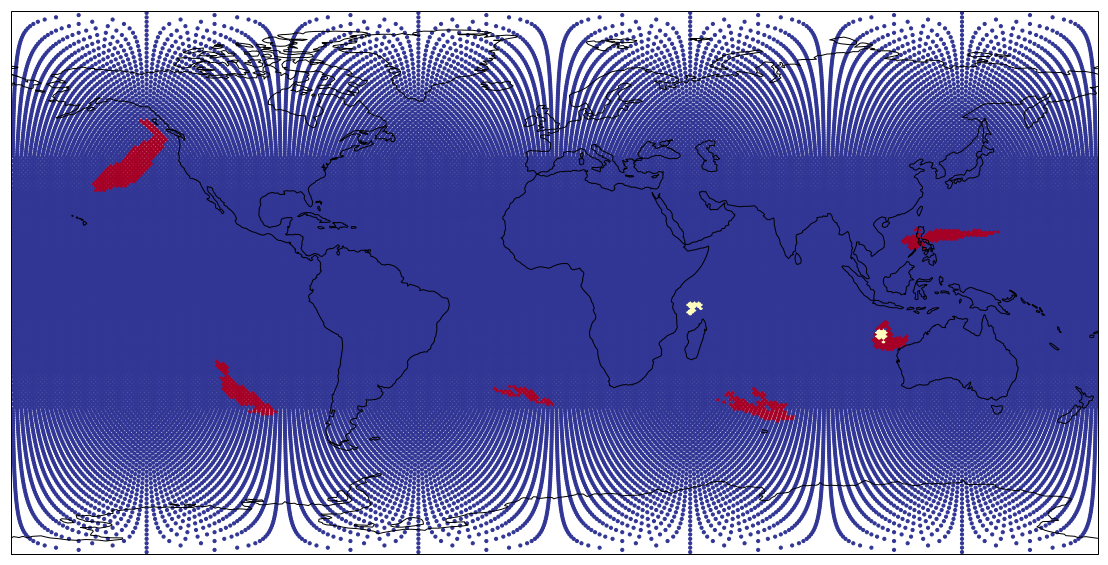

In [95]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
            c=new_labels, cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

## data

In [74]:
from glob import glob
year = 2106
path = '../../data/Climate/data-{}-01*.h5'.format(year)
files = glob(path)
datas = np.zeros((len(files),16,768,1152))
labels = np.zeros((len(files),768,1152))
for i, file in enumerate(files):
#     _, _, month, day, hour, run = file.split('-')
#     month, day, hour, run = int(month), int(day), int(hour), int(run[0])
    data = h5py.File(file)
    datas[i] = data['climate']['data']
    labels[i] = data['climate']['labels']

In [107]:
from glob import glob
year = 2106
path = '../../data/Climate/data-{}-01*.npz'.format(year)
files = glob(path)
datas = np.zeros((len(files),12288,16))
labels = np.zeros((len(files),12288))
for i, file in enumerate(files):
#     _, _, month, day, hour, run = file.split('-')
#     month, day, hour, run = int(month), int(day), int(hour), int(run[0])
    data = np.load(file)
    datas[i] = data['datas']
    labels[i] = data['labels']
#     datas.append(data)
#     labels.append(label)
# datas = np.stack(datas)
# labels = np.stack(labels)

In [110]:
limit=20
x_train = datas[:limit,:,:]
labels_train = labels[:limit,:]
x_val = datas[limit:,:,:]
labels_val = labels[limit:,:]

training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

## Training

In [111]:
EXP_NAME = 'TestClimate'

In [113]:
nside=32

In [122]:
import tensorflow as tf
params = {'nsides': [nside, nside,nside//2,nside//4,nside//8,nside//16,nside//32, nside//32],
          'F': [20, 20, 50, 80, 100, 200, 400],#np.max(labels_train).astype(int)+1],
          'K': [4]*7,
          'batch_norm': [True]*7}
params['dir_name'] = EXP_NAME
params['num_feat_in'] = x_train.shape[-1] # 2*days_pred+3
params['conv'] = 'chebyshev5'
params['pool'] = 'average'
params['activation'] = 'relu'
params['statistics'] = None#'mean'
params['regularization'] = 0
params['dropout'] = 1
params['num_epochs'] = 1000  # Number of passes through the training data.
params['batch_size'] = 8
params['scheduler'] = lambda step: tf.train.exponential_decay(1e-3, step, decay_steps=2000, decay_rate=1)
#params['optimizer'] = lambda lr: tf.train.GradientDescentOptimizer(lr)
params['optimizer'] = lambda lr: tf.train.RMSPropOptimizer(lr, decay=0.9, momentum=0.)
n_evaluations = 10
params['eval_frequency'] = int(params['num_epochs'] * (training.N) / params['batch_size'] / n_evaluations)
params['M'] = []
params['Fseg'] = np.max(labels_train).astype(int)+1
params['dense'] = True

In [123]:
print([12*nside**2 for nside in params['nsides']])
model = models.deepsphere(**params)

[12288, 12288, 3072, 768, 192, 48, 12, 12]
NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 20 / 1 = 245760
    weights: F_0 * F_1 * K_1 = 16 * 20 * 4 = 1280
    biases: F_1 = 20
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 12288 * 20 / 4 = 61440
    weights: F_1 * F_2 * K_2 = 20 * 20 * 4 = 1600
    biases: F_2 = 20
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 3072 * 50 / 4 = 38400
    weights: F_2 * F_3 * K_3 = 20 * 50 * 4 = 4000
    biases: F_3 = 50
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 768 * 80 / 4 = 15360
    weights: F_3 * F_4 * K_4 = 50 * 80 * 4 = 16000
    biases: F_4 = 80
    batch normalization
  layer 5: cgconv5
    representation: M_4 * F_5 / p_5 = 192 * 100 / 4 = 4800
    weights: F_4 * F_5 * K_5 = 80 * 100 * 4 = 32000
    biases: F_5 = 100
    batch normalization
  layer 6: cgconv6
    representation: M_5 * 

In [124]:
model.fit(training, validation)

step 250 / 2500 (epoch 100.00 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.98, training loss = 5.28e-02


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 98.22 (48277 / 49152), f1 (weighted): 97.37, loss: 7.56e-02
  CPU time: 24s, wall time: 29s, perf_time_load: 0.094s, perf_time: 0.097s
step 500 / 2500 (epoch 200.00 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.95e-02
  validation accuracy: 98.21 (48270 / 49152), f1 (weighted): 97.34, loss: 1.02e-01
  CPU time: 46s, wall time: 57s, perf_time_load: 0.088s, perf_time: 0.092s
step 750 / 2500 (epoch 300.00 / 1000):
  learning_rate = 1.00e-03, training accuracy = 0.99, training loss = 1.29e-02
  validation accuracy: 98.67 (48498 / 49152), f1 (weighted): 98.61, loss: 4.34e-02
  CPU time: 66s, wall time: 82s, perf_time_load: 0.090s, perf_time: 0.093s
step 1000 / 2500 (epoch 400.00 / 1000):
  learning_rate = 1.00e-03, training accuracy = 1.00, training loss = 1.02e-02
  validation accuracy: 97.92 (48131 / 49152), f1 (weighted): 97.84, loss: 1.08e-01
  CPU time: 84s, wall time: 106s, perf_time_load: 0.088s, perf_time: 0.092s
step 1250 / 

([98.21980794270834,
  98.20556640625,
  98.66943359375,
  97.92277018229166,
  98.25032552083334,
  97.3876953125,
  98.94002278645834,
  98.2421875,
  98.59619140625,
  98.96240234375],
 [0.07560232281684875,
  0.10241483896970749,
  0.04343969747424126,
  0.10788626223802567,
  0.21272911131381989,
  0.20304624736309052,
  0.0534537248313427,
  0.21139858663082123,
  0.12629637122154236,
  0.04991680383682251],
 [0.052762415,
  0.019474335,
  0.012879522,
  0.010186535,
  0.0052771443,
  0.010927842,
  0.0021866176,
  0.008765739,
  0.00044643926,
  0.0012306012],
 0.10198011436462402,
 0.09530598673857749)

In [ ]:
x_train.shape

In [125]:
predictions = model.predict(x_train)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/TestClimate/model-2500


In [133]:
coords_hp.shape

(49152, 2)

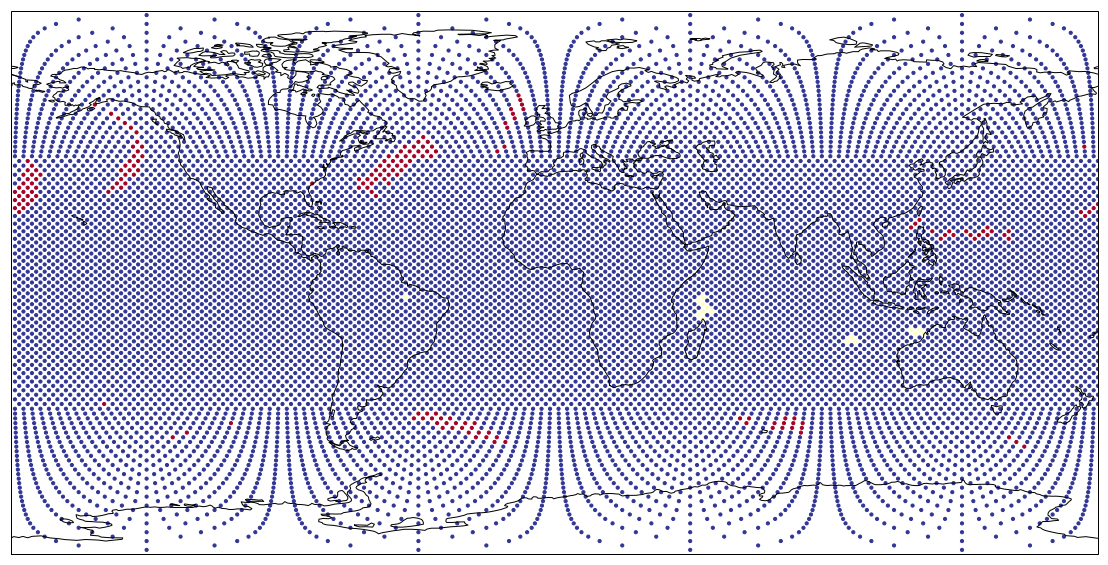

In [135]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
            c=predictions[0,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)